In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms

from src.utils.data_utils import TGIF
from src.utils.trainer import ModelTrainer

from src.models.autoencoder import Autoencoder
from src.utils.initializer import Initializer

import numpy as np
import os

%load_ext autoreload
%autoreload 2

In [9]:
TEST_MODEL_PATH = os.path.join(os.getcwd(), 'src', 'experiments', 'vae-imagenet')
IMAGE_SZ = (64, 64)
MAX_GIF_FRAMES = 10
NUM_WORKERS = 4

GIF_DATASET_ROOT = os.path.join(os.getcwd(), 'src/datasets/GGIF/GIFs/nature')
IMG_DATASET_ROOT = os.path.join(os.getcwd(), 'src/datasets/TinyImageNet')

IMG_BATCH_SZ = 128
GIF_BATCH_SZ = 64

TRANSFORMS = transforms.Compose([transforms.Resize(IMAGE_SZ), transforms.ToTensor()])
DISP_LIM = 8

In [10]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using device:', device)
print('Using type:', dtype)

Using device: cuda
Using type: torch.float32


In [11]:
gif_train_set = TGIF(root=f'{GIF_DATASET_ROOT}/train', max_frames=MAX_GIF_FRAMES, transform=TRANSFORMS)
gif_val_set = TGIF(root=f'{GIF_DATASET_ROOT}/val', max_frames=MAX_GIF_FRAMES, transform=TRANSFORMS)
gif_test_set = TGIF(root=f'{GIF_DATASET_ROOT}/test', max_frames=MAX_GIF_FRAMES, transform=TRANSFORMS)

print(len(gif_train_set), len(gif_val_set), len(gif_test_set))

3995 748 249


In [12]:
img_train_set = dset.ImageFolder(f'{IMG_DATASET_ROOT}/train', transform=TRANSFORMS)
img_val_set = dset.ImageFolder(f'{IMG_DATASET_ROOT}/test', transform=TRANSFORMS)
img_test_set = dset.ImageFolder(f'{IMG_DATASET_ROOT}/val', transform=TRANSFORMS)

print(len(img_train_set), len(img_val_set), len(img_test_set))

100000 10000 10000


In [6]:
gif_train_loader = DataLoader(gif_train_set, batch_size=GIF_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
gif_val_loader = DataLoader(gif_val_set, batch_size=GIF_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
gif_test_loader = DataLoader(gif_val_set, batch_size=GIF_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

In [7]:
img_train_loader = DataLoader(img_train_set, batch_size=IMG_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
img_val_loader = DataLoader(img_val_set, batch_size=IMG_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)
img_test_loader = DataLoader(img_val_set, batch_size=IMG_BATCH_SZ, shuffle=True, drop_last=True, num_workers=NUM_WORKERS)

NameError: name 'img_train_set' is not defined

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

def img_show(gif):
    npimg = gif.numpy()
    out = np.transpose(npimg, (1, 2, 0))
    plt.figure(figsize=(20,40))
    plt.imshow(out)

def plot_frame_double(index, real, fake):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    fig.subplots_adjust(hspace=0)
    
    real = real.numpy()
    real = np.transpose(real, (1, 2, 0))
    
    fake = fake.numpy()
    fake = np.transpose(fake, (1, 2, 0))
    
    axes[0].imshow(real)
    axes[0].set_title(f'[REAL] Frame #{index + 1}')
    
    axes[1].imshow(fake)
    axes[1].set_title(f'[FAKE] Frame #{index + 1}')
    plt.gcf().show()    

def plot_frame_single(index, frame):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    fig.subplots_adjust(hspace=0)
    npframe = frame.numpy()
    npframe = np.transpose(npframe, (1, 2, 0))
    ax.imshow(npframe)
    ax.set_title(f'FRAME #{index + 1}')
    plt.gcf().show()

In [16]:
%matplotlib inline
from IPython import display
import time

def display_loop(limit):
    for i, gifs in enumerate(gif_train_loader):
        for index, (frame1, frame2) in enumerate(zip(gifs[0], gifs[1])):
            plot_frame_double(index, frame1, frame2)
            
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(0.15)
        if i == limit:
            break
# display_loop(5)

torch.Size([40, 3, 64, 64])


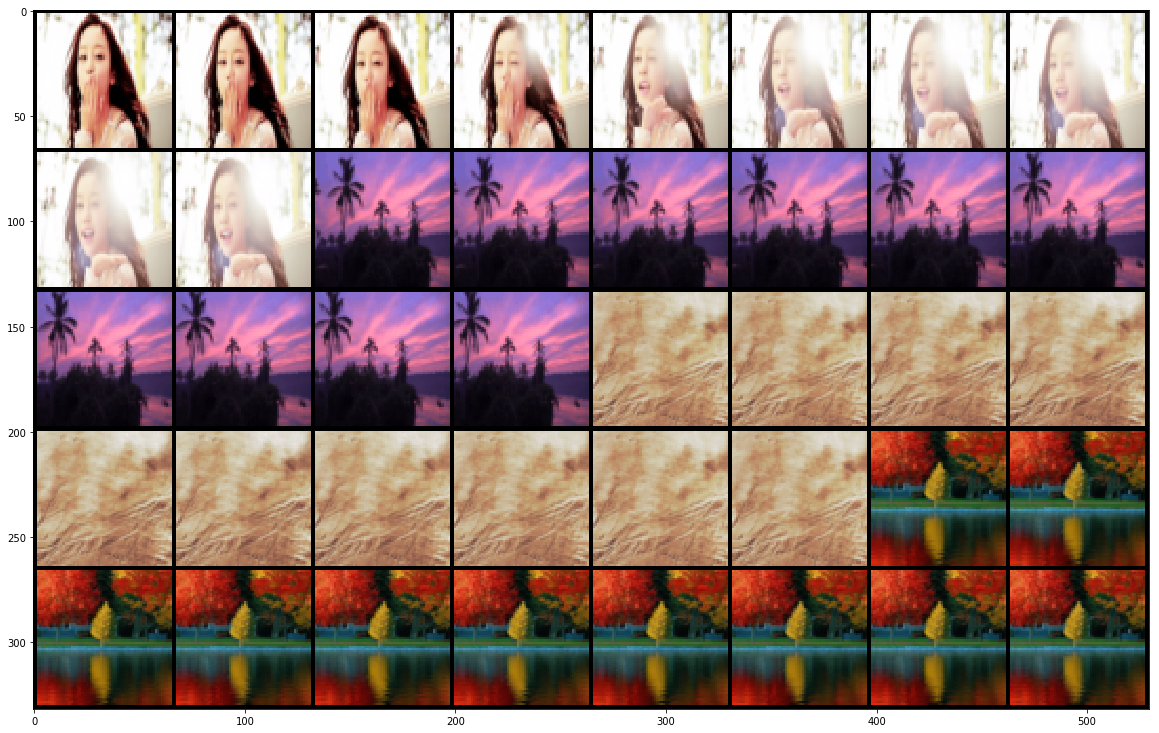

In [14]:
%matplotlib inline
gifs = []
for i, gif in enumerate(gif_train_loader):
    gifs.append(gif[0])
    if i == 3:
        break
gif = torch.cat(tuple(gifs), dim=0)
print (gif.shape)
img_show(torchvision.utils.make_grid(gif))

torch.Size([128, 3, 64, 64])


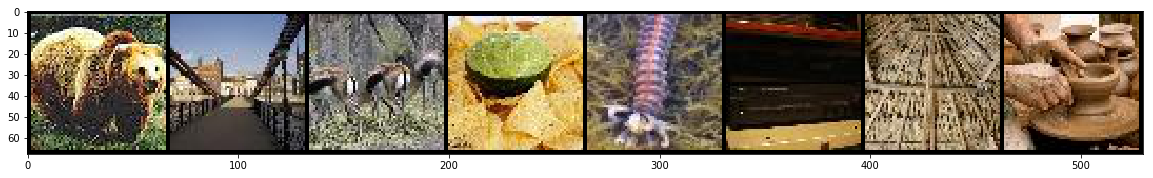

In [15]:
%matplotlib inline
img = iter(img_train_loader).next()[0]
print (img.shape)
img_show(torchvision.utils.make_grid(img[:DISP_LIM]))

In [16]:
def loss_fn(recon_x, x):
    p = 1
    mse_loss = nn.MSELoss(size_average=False)
    MSE = mse_loss(recon_x, x)

    GDL_1 = torch.abs(torch.abs(recon_x[:, :, :, :-1] - recon_x[:, :, :, 1:]) - torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:])) ** p
    GDL_2 = torch.abs(torch.abs(recon_x[:, :, :-1, :] - recon_x[:, :, 1:, :]) - torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :])) ** p
    GDL =  (torch.sum(GDL_1) + torch.sum(GDL_2))/x.shape[0]

    return MSE + GDL

def train_fn(model, optimizer, inp):        
    model.train()
    x = inp[0]
    x = x.to(device=device, dtype=dtype)
    recon_x = model(x)

    loss = loss_fn(recon_x, x)
    loss.cuda().backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()

In [17]:
def validation_loss (model, val_loader): 
    def validation_loss_batch (model, inp):           
        model.eval()
        x = inp[0]
        x = x.to(device=device, dtype=dtype)
        recon_x = model(x)

        loss = loss_fn(recon_x, x)
        return loss.item()

    loss = 0
    batch_count = 0
    for batch in val_loader:
        loss += validation_loss_batch (model, batch)
        batch_count += 1
    return loss / batch_count

In [18]:
def img_test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x[0]
    print (x.shape)
    x = torch.tensor(x)
    x = x.to(device=device, dtype=dtype)
    y = model(x)
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    img_show(torchvision.utils.make_grid(imgs))
    
def gif_test_autoenc(model, loader):
    model.eval()
    dataiter = iter(loader)
    x = dataiter.next()
    x = x[:, 0]
    x = x.to(device=device, dtype=dtype)
    y = model(x)
    x = x.to(torch.device('cpu')).detach()
    y = torch.clamp(y.to(torch.device('cpu')).detach(), 0, 1)
    imgs = torch.cat([x[:DISP_LIM], y[:DISP_LIM]])
    img_show(torchvision.utils.make_grid(imgs))

In [19]:
NUM_CHANNELS = 3
INPUT_SIZE = IMAGE_SZ[0] * IMAGE_SZ[1] * NUM_CHANNELS

net = Autoencoder(latent_size=100, device=device)
Initializer.initialize(model=net, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))
optimizer = optim.Adam(net.parameters(), lr=1.5e-3)
trainer = ModelTrainer(net, optimizer, train_fn, TEST_MODEL_PATH, save_models=False)

In [58]:
try:
    print('Starting training (batch size )...')
    trainer.train(img_train_loader, epochs=4, print_every=100, save_every=100)
except KeyboardInterrupt:
    print("Force saving")
    trainer.save_data(force_save=True)

Starting training (batch size )...
Epoch [0] (0/781), loss = 1580109.1250
Epoch [0] (100/781), loss = 70282.0312
Epoch [0] (200/781), loss = 51230.2852
Epoch [0] (300/781), loss = 49639.5117
Epoch [0] (400/781), loss = 45397.0234
Epoch [0] (500/781), loss = 41066.4883
Epoch [0] (600/781), loss = 41832.0938
Epoch [0] (700/781), loss = 34726.2500
Epoch [0] done
Epoch [1] (0/781), loss = 39604.6719
Epoch [1] (100/781), loss = 36165.2578
Epoch [1] (200/781), loss = 39396.6836
Epoch [1] (300/781), loss = 34166.1641
Epoch [1] (400/781), loss = 32529.3750
Epoch [1] (500/781), loss = 34153.2500
Epoch [1] (600/781), loss = 36097.9805
Epoch [1] (700/781), loss = 29979.7598
Epoch [1] done
Epoch [2] (0/781), loss = 33100.4609
Epoch [2] (100/781), loss = 32203.6875
Epoch [2] (200/781), loss = 30502.0879
Epoch [2] (300/781), loss = 31685.0742
Epoch [2] (400/781), loss = 31553.6328
Epoch [2] (500/781), loss = 30278.4102
Epoch [2] (600/781), loss = 33237.7148
Epoch [2] (700/781), loss = 26029.7734
Epo

torch.Size([128, 3, 64, 64])


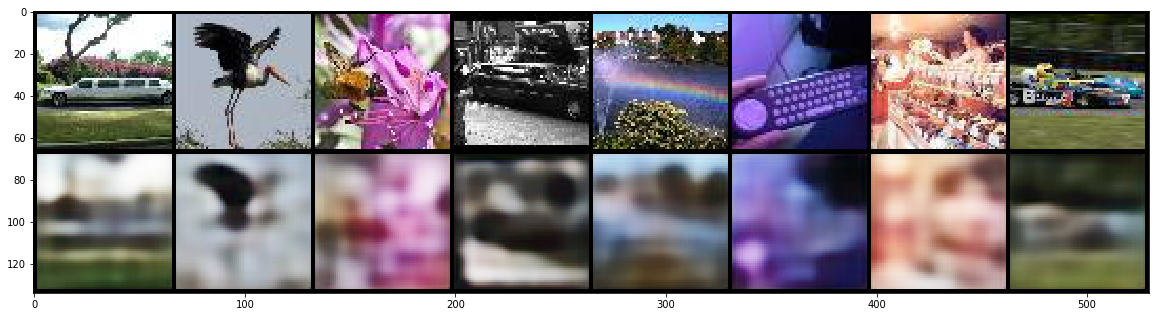

In [64]:
img_test_autoenc(net, img_train_loader)

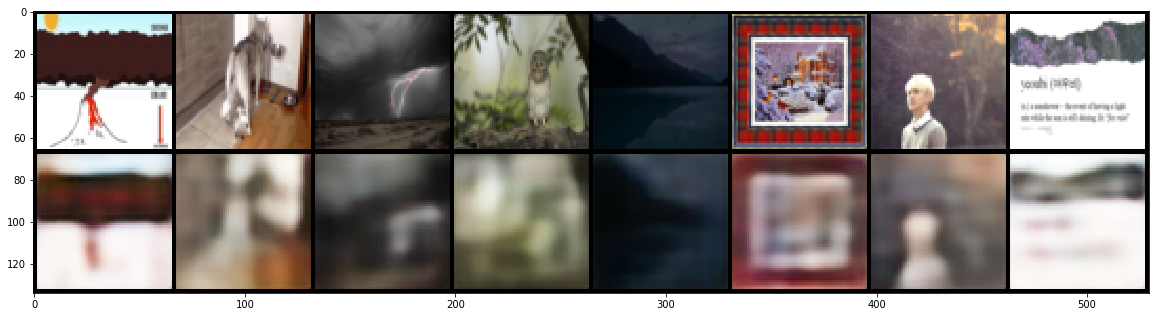

In [69]:
gif_test_autoenc(net, gif_val_loader)

In [20]:
HISTORY = [(0.16311506955549732, 2290, 52864.921875), (0.00796509072247531, 1150, 32886.71424278846), (0.010878694865187112, 2010, 38525.689002403844), (0.0005060987987746227, 2370, 31721.70487780449), (1.6382250333786812e-06, 1470, 119442.78175080128), (0.008672683230324406, 2720, 45066.09024439102), (3.931368685361305e-06, 890, 100115.29797676283), (0.8078465170967358, 970, 624054.797275641), (0.0002366567013896217, 1560, 32917.01169370994), (7.407286502583523e-05, 1430, 37670.56850961538), (2.334647046569041e-05, 280, 60521.531199919875), (0.05951445119510739, 2470, 44547.10586939102), (3.7975143848605344e-06, 210, 85626.05198317308), (0.005293264162137334, 1510, 36096.53475560898), (2.4607424990657197e-06, 2870, 98253.09495192308), (0.15752720352011526, 830, 624157.1434294871), (0.0004281583295242738, 920, 31192.16418770032), (2.3788367420318324e-06, 1430, 292365.33173076925), (2.027847840600706e-06, 1810, 128600.01973157052), (0.021709027628071337, 1880, 40612.960987580125), (0.5180464789269221, 1250, 624172.1049679487), (0.0022747803042124817, 1320, 35725.34154647436), (0.259951131983087, 190, 624063.21875), (3.1284254190673255e-06, 380, 88821.74699519231), (2.9977312704933807e-05, 1660, 45291.35021033654), (3.732009171421129e-05, 1020, 45222.22375801282)]

In [23]:
TUNE_EPOCHS_COARSE = 2
TUNE_EPOCHS_FINE = 5
TUNE_FINE_N = 6
TUNE_COARSE_N = 30
TUNE_STATS_COARSE_ROOT = os.path.join(os.getcwd(), 'src', 'experiments', 'ae-tune-imagenet-coarse')
TUNE_STATS_FINE_ROOT = os.path.join(os.getcwd(), 'src', 'experiments', 'ae-tune-imagenet-fine')

def tune_hyperparams_fine(lr_base, latent_sz_base):
    history = []
    
    best_lr = lr_base
    best_latent_sz = latent_sz_base
    best_loss = float('inf')

    tune_offsets_lr = [lr_base / denom for denom in [2, 4, 8]]
    tune_offsets_latent_sz = [latent_sz_base / denom for denom in [2, 4, 8]]

    for lr_offset, latent_sz_offset in zip(tune_offsets_lr, tune_offsets_latent_sz):
        print ('  [FINE] Narrowing offsets...')
        for i in range(TUNE_FINE_N):
            lr = max(best_lr + (np.random.rand() * 2 - 1) * lr_offset, 1e-10)
            latent_sz = max(best_latent_sz + int((np.random.rand() * 2 - 1) * latent_sz_offset), 20)
            
            print (f'  [FINE] [lr = {lr}, latent_sz = {latent_sz}] ', end="")
            
            net = Autoencoder(latent_size=latent_sz, 
                              device=device)
            
            Initializer.initialize(model=net,
                                   initialization=init.xavier_uniform_,
                                   gain=init.calculate_gain('relu'))
            
            optimizer = optim.Adam(net.parameters(), 
                                   lr=lr)
            
            trainer = ModelTrainer(net, 
                                   optimizer, 
                                   train_fn, 
                                   TUNE_STATS_FINE_ROOT,
                                   tags=['ae-tune', 'fine'],
                                   save_models=False)

            trainer.train(img_train_loader, 
                          verbose=False,
                          epochs=TUNE_EPOCHS_FINE,
                          save_every=200)

            loss = validation_loss(net, img_val_loader)
            history.append((lr, latent_sz, loss))
            HISTORY.append((lr, latent_sz, loss))

            print (f'Validation loss: {loss}')

            if loss < best_loss:
                print (f'  [FINE]     [new best] Old best ({best_loss}) > new best ({loss})')
                best_lr = lr
                best_latent_sz = latent_sz
                best_loss = loss
                gif_test_autoenc(net, gif_val_loader)
            
    print (f'  [FINE] Done.')
    print ()
    print (f'  [FINE] Best learning rate = {all_best_lr}')
    print (f'  [FINE] Best latent size = {all_best_latent_sz}')
    return best_loss, best_lr, best_latent_sz, history
    
def tune_hyperparams_coarse(llr_lower, llr_upper, llatent_sz_lower, llatent_sz_upper):
    history = []
    
    best_lr = None
    best_latent_sz = None
    best_loss = float('inf')

    for i in range(TUNE_COARSE_N):
        lr = 10 ** -np.random.uniform(llr_lower, llr_upper)
        latent_sz = 10 * np.random.randint(llatent_sz_lower, llatent_sz_upper)

        print (f'[COARSE] [lr = {lr}, latent_sz = {latent_sz}] ', end="")

        net = Autoencoder(latent_size=latent_sz, 
                        device=device)

        Initializer.initialize(model=net,
                               initialization=init.xavier_uniform_,
                               gain=init.calculate_gain('relu'))

        optimizer = optim.Adam(net.parameters(), 
                               lr=lr)

        trainer = ModelTrainer(net, 
                               optimizer, 
                               train_fn, 
                               TUNE_STATS_COARSE_ROOT,
                               tags=['ae-tune', 'coarse'],
                               save_models=False)

        trainer.train(img_train_loader,
                      verbose=False,
                      epochs=TUNE_EPOCHS_COARSE,
                      save_every=200)

        loss = validation_loss(net, img_val_loader)

        print (f'Validation loss: {loss}')
        
        history.append((lr, latent_sz, loss))
        HISTORY.append((lr, latent_sz, loss))

        if loss < best_loss:
            print (f'[COARSE]     [NEW BEST] Old best ({best_loss}) > new best ({loss})')
            best_lr = lr
            best_latent_sz = latent_sz
            best_loss = loss
            gif_test_autoenc(net, gif_val_loader)
            
    print (f'[COARSE] Done.')
    print ()
    print (f'[COARSE] Best learning rate = {best_lr}')
    print (f'[COARSE] Best latent size = {best_latent_sz}')
    return best_loss, best_lr, best_latent_sz, history

[COARSE] [lr = 0.16311506955549732, latent_sz = 2290] Validation loss: 52864.921875
[COARSE]     [NEW BEST] Old best (inf) > new best (52864.921875)
[COARSE] [lr = 0.00796509072247531, latent_sz = 1150] Validation loss: 32886.71424278846
[COARSE]     [NEW BEST] Old best (52864.921875) > new best (32886.71424278846)
[COARSE] [lr = 0.010878694865187112, latent_sz = 2010] Validation loss: 38525.689002403844
[COARSE] [lr = 0.0005060987987746227, latent_sz = 2370] Validation loss: 31721.70487780449
[COARSE]     [NEW BEST] Old best (32886.71424278846) > new best (31721.70487780449)
[COARSE] [lr = 1.6382250333786812e-06, latent_sz = 1470] Validation loss: 119442.78175080128
[COARSE] [lr = 0.008672683230324406, latent_sz = 2720] Validation loss: 45066.09024439102
[COARSE] [lr = 3.931368685361305e-06, latent_sz = 890] Validation loss: 100115.29797676283
[COARSE] [lr = 0.8078465170967358, latent_sz = 970] Validation loss: 624054.797275641
[COARSE] [lr = 0.0002366567013896217, latent_sz = 1560] V

OSError: [Errno 12] Cannot allocate memory

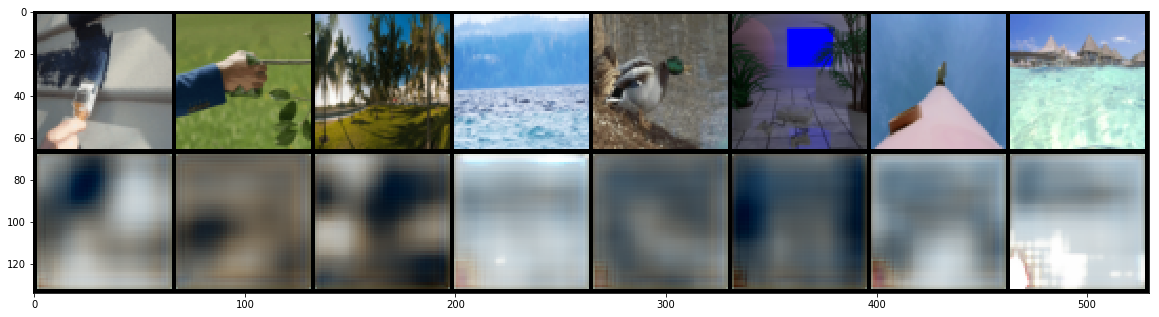

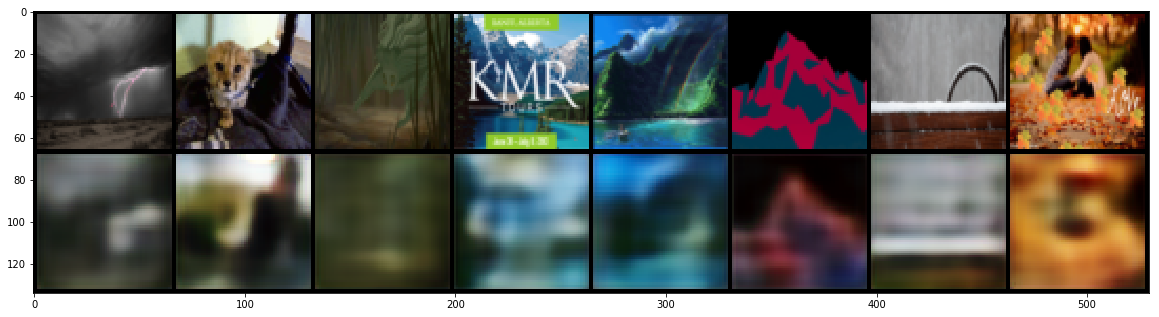

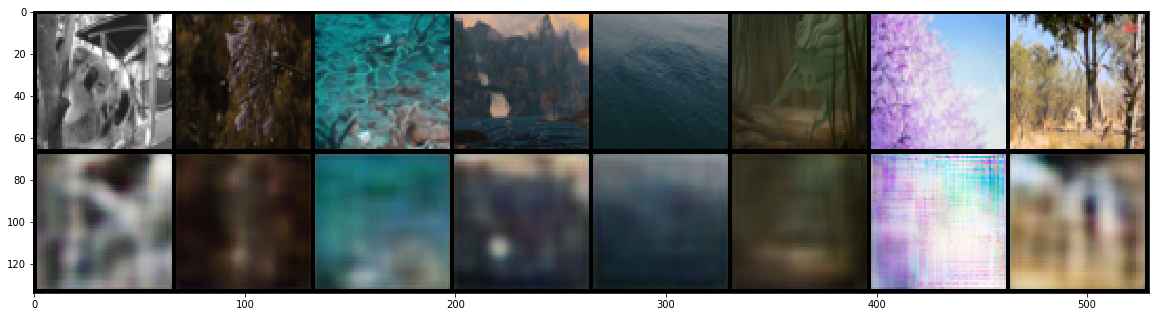

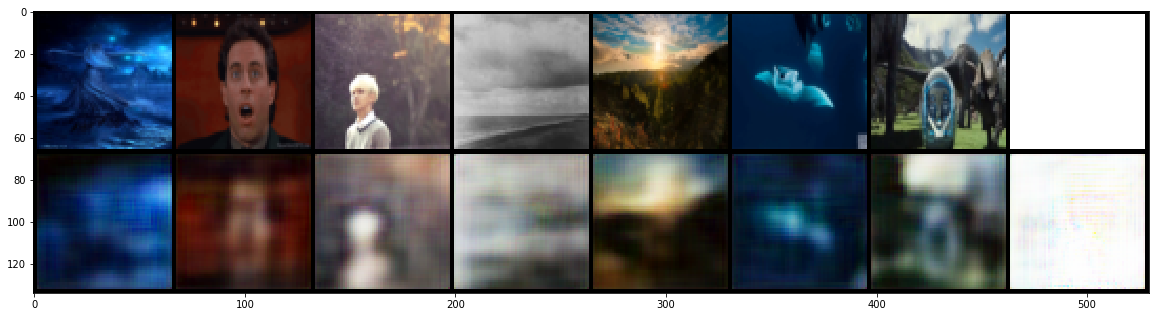

In [212]:
best_loss_coarse, best_lr_coarse, best_latent_sz_coarse, history_coarse = tune_hyperparams_coarse(0, 6, 10, 300)

[FINE] Narrowing offsets...
  [FINE] [lr = 0.0003283035592954567, latent_sz = 752] Validation loss: 26577.43609775641
  [FINE]     [new best] Old best (inf) > new best (26577.43609775641)
  [FINE] [lr = 0.0005224644152478743, latent_sz = 382] Validation loss: 26633.794896834937
  [FINE] [lr = 0.0004589709472065587, latent_sz = 1089] Validation loss: 25927.30583934295
  [FINE]     [new best] Old best (26577.43609775641) > new best (25927.30583934295)
  [FINE] [lr = 0.0002469665589866896, latent_sz = 997] Validation loss: 27708.883138020832
  [FINE] [lr = 0.0004973432200580544, latent_sz = 1013] Validation loss: 25958.603415464742
  [FINE] [lr = 0.00044325518595689136, latent_sz = 1126] Validation loss: 25974.761268028848
[FINE] Narrowing offsets...
  [FINE] [lr = 0.0003708815908742202, latent_sz = 952] Validation loss: 26560.63373898237
  [FINE] [lr = 0.0004601254054757922, latent_sz = 1015] Validation loss: 25695.482196514422
  [FINE]     [new best] Old best (25927.30583934295) > new b

Process Process-248:
KeyboardInterrupt
Process Process-246:
Process Process-245:
Process Process-247:
Traceback (most recent call last):
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/shared/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in default_collate
    return [default_collate(samples) for samples in transposed]
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 138, in <listcomp>
    return [default_collate(samples) for samples in transposed]
  File "/home/shared/anaconda3/lib/python3.6/site-packages/torch/utils

KeyboardInterrupt: 

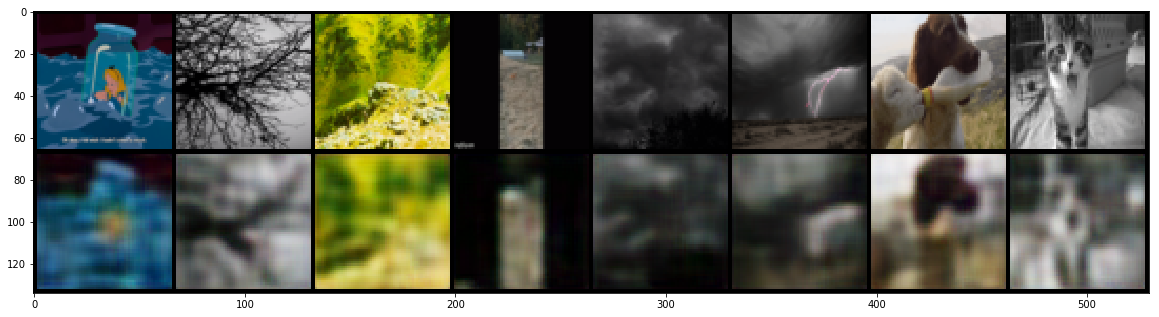

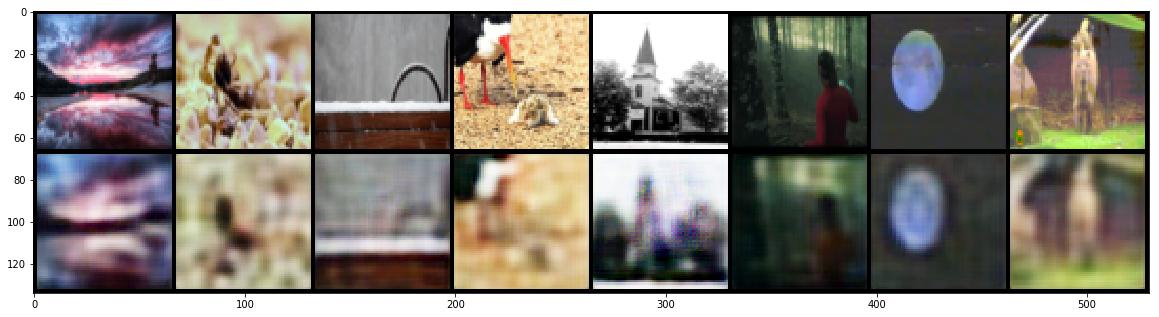

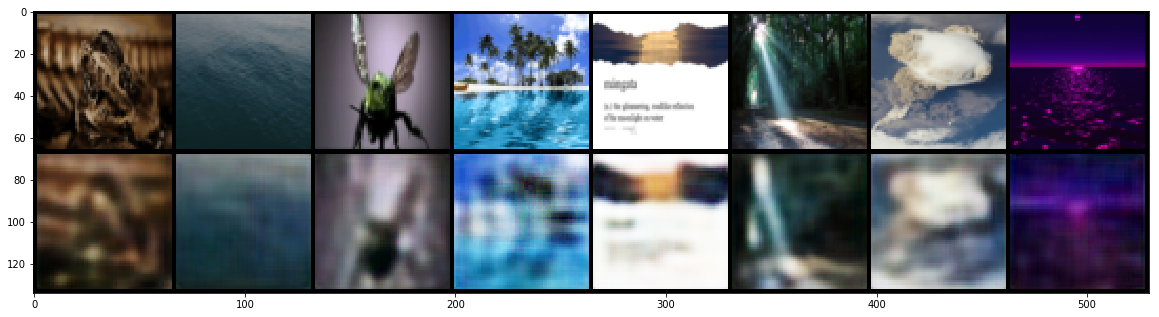

In [24]:
best_lr_coarse, best_latent_sz_coarse = 0.0004281583295242738, 920
best_loss_fine, best_lr_fine, best_latent_sz_fine, history_fine = tune_hyperparams_fine(best_lr_coarse, best_latent_sz_coarse)

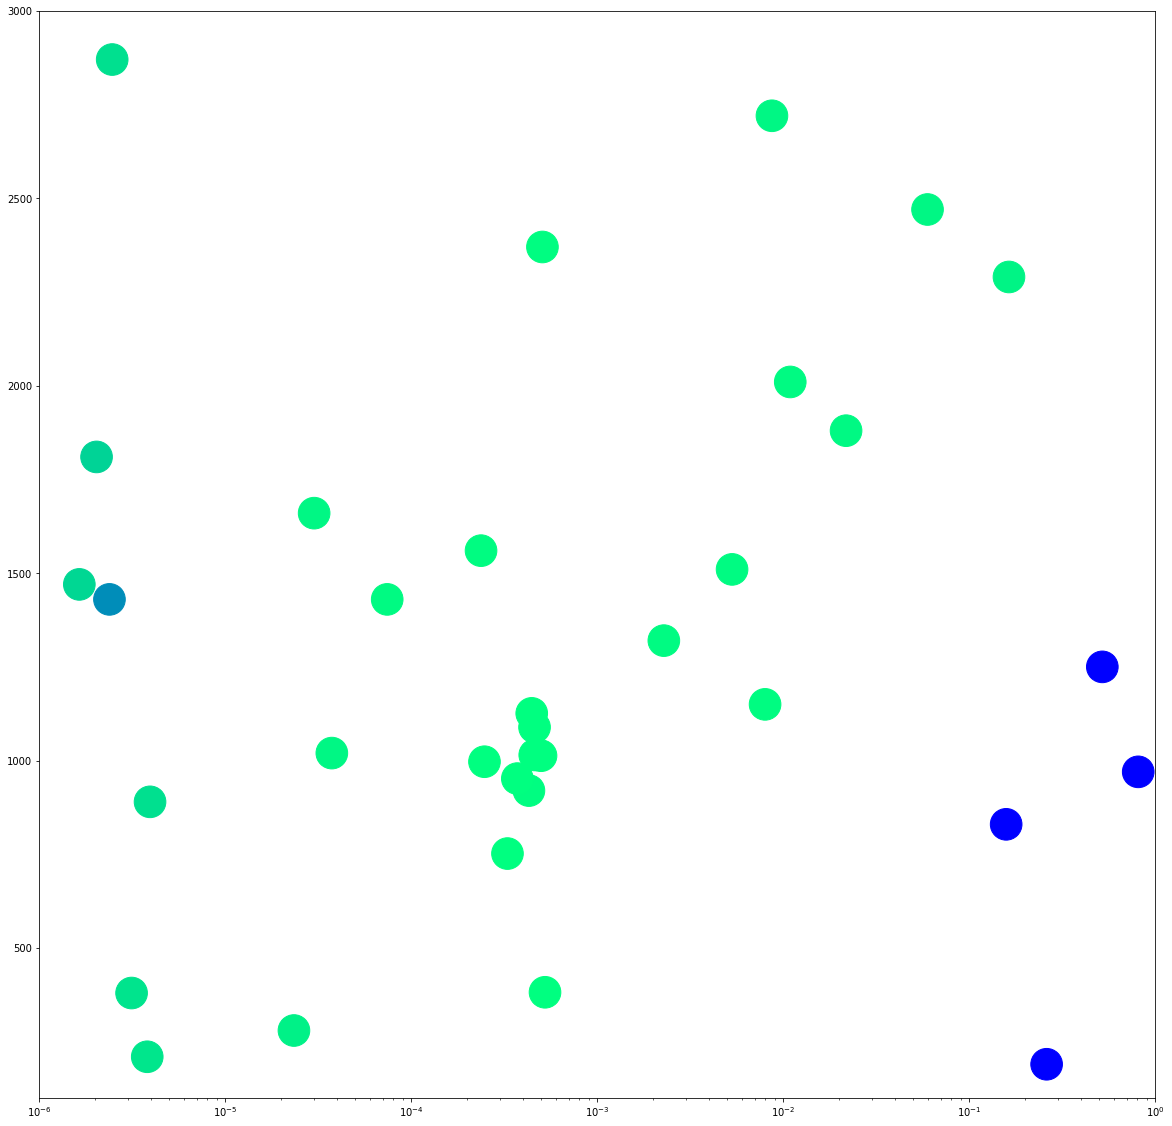

loss = 25695.482196514422 ==> [lr = 0.0004601254054757922, hidden_sz = 1015]
loss = 25927.30583934295 ==> [lr = 0.0004589709472065587, hidden_sz = 1089]
loss = 25958.603415464742 ==> [lr = 0.0004973432200580544, hidden_sz = 1013]
loss = 25974.761268028848 ==> [lr = 0.00044325518595689136, hidden_sz = 1126]
loss = 26560.63373898237 ==> [lr = 0.0003708815908742202, hidden_sz = 952]
loss = 26577.43609775641 ==> [lr = 0.0003283035592954567, hidden_sz = 752]
loss = 26633.794896834937 ==> [lr = 0.0005224644152478743, hidden_sz = 382]
loss = 27708.883138020832 ==> [lr = 0.0002469665589866896, hidden_sz = 997]
loss = 31192.16418770032 ==> [lr = 0.0004281583295242738, hidden_sz = 920]
loss = 31721.70487780449 ==> [lr = 0.0005060987987746227, hidden_sz = 2370]
loss = 32886.71424278846 ==> [lr = 0.00796509072247531, hidden_sz = 1150]
loss = 32917.01169370994 ==> [lr = 0.0002366567013896217, hidden_sz = 1560]
loss = 35725.34154647436 ==> [lr = 0.0022747803042124817, hidden_sz = 1320]
loss = 36096.

In [27]:
import math

def plot_history(hist):
    x, y, c = [], [], []
    for index, (lr, sz, loss) in enumerate(sorted(hist, key=lambda z: -z[2])):
        x.append(lr)
        y.append(sz)
        c.append(-loss)
#         if index > len(hist) - 4:
#             c.append('green')
#         elif index < 4:
#             c.append('red')
#         else:
#             c.append('yellow')
    plt.figure(figsize=(20,20))
    plt.xscale('log')

    plt.ylim(100, 3000)
    plt.xlim(1e-6, 1e0)
    plt.scatter(x, y, c=c, s=1000, cmap='winter', norm=mpl.colors.Normalize(vmin=min(c), vmax=max(c)))
#     plt.scatter(x, y, c=c, s=1000)
    
    plt.show()
    
def print_history(hist):
    hist = sorted(hist, key=lambda x: x[2])
    for lr, sz, loss in hist:
        print (f'loss = {loss} ==> [lr = {lr}, hidden_sz = {sz}]')
    
plot_history(HISTORY)
print_history(HISTORY)
print(HISTORY)

In [28]:
BEST_MODEL_ROOT = os.path.join(os.getcwd(), 'src', 'experiments', f'ae-tune-imagenet-best')

net = Autoencoder(latent_size=1015, device=device)
Initializer.initialize(model=net, initialization=init.xavier_uniform_, gain=init.calculate_gain('relu'))
optimizer = optim.Adam(net.parameters(), lr=0.0004601254054757922)
trainer = ModelTrainer(net, optimizer, train_fn, BEST_MODEL_ROOT, tags=['ae-tune', 'best'], save_models=False)

print ('Training best model...')
trainer.train(img_train_loader, epochs=20, print_every=100, save_every=100)
trainer.save_data(force_save=True)
print ('Done!')

Training best model...
Epoch [0] (0/781), loss = 918571.1250
Epoch [0] (100/781), loss = 69168.8438
Epoch [0] (200/781), loss = 51188.7109
Epoch [0] (300/781), loss = 53648.0234
Epoch [0] (400/781), loss = 43448.8320
Epoch [0] (500/781), loss = 40843.7305
Epoch [0] (600/781), loss = 39225.4219
Epoch [0] (700/781), loss = 36643.6641
Epoch [0] done
Epoch [1] (0/781), loss = 35736.9219
Epoch [1] (100/781), loss = 35881.4961
Epoch [1] (200/781), loss = 33123.4609
Epoch [1] (300/781), loss = 35366.8867
Epoch [1] (400/781), loss = 34897.5977
Epoch [1] (500/781), loss = 33128.9570
Epoch [1] (600/781), loss = 32998.1797
Epoch [1] (700/781), loss = 28741.2461
Epoch [1] done
Epoch [2] (0/781), loss = 31505.2148
Epoch [2] (100/781), loss = 29900.0078
Epoch [2] (200/781), loss = 29912.4219
Epoch [2] (300/781), loss = 30062.6953
Epoch [2] (400/781), loss = 29710.6992
Epoch [2] (500/781), loss = 29607.2383
Epoch [2] (600/781), loss = 30465.3984
Epoch [2] (700/781), loss = 27728.7539
Epoch [2] done
E

In [34]:
trainer.train(img_train_loader, epochs=5, print_every=100, save_every=100)
trainer.save_data(force_save=True)

Epoch [0] (0/781), loss = 14434.0918
Epoch [0] (100/781), loss = 16260.0898
Epoch [0] (200/781), loss = 14677.2295
Epoch [0] (300/781), loss = 15067.6826
Epoch [0] (400/781), loss = 15347.0967
Epoch [0] (500/781), loss = 15015.9785
Epoch [0] (600/781), loss = 14419.2246
Epoch [0] (700/781), loss = 15284.1240
Epoch [0] done
Epoch [1] (0/781), loss = 15334.0967
Epoch [1] (100/781), loss = 16191.9580
Epoch [1] (200/781), loss = 17309.6016
Epoch [1] (300/781), loss = 15205.1016
Epoch [1] (400/781), loss = 15010.0508
Epoch [1] (500/781), loss = 15846.7979
Epoch [1] (600/781), loss = 16054.1738
Epoch [1] (700/781), loss = 16992.4531
Epoch [1] done
Epoch [2] (0/781), loss = 14763.2627
Epoch [2] (100/781), loss = 15095.6035
Epoch [2] (200/781), loss = 14698.8184
Epoch [2] (300/781), loss = 15079.2793
Epoch [2] (400/781), loss = 15264.6133
Epoch [2] (500/781), loss = 13866.8711
Epoch [2] (600/781), loss = 14129.9824
Epoch [2] (700/781), loss = 15997.1836
Epoch [2] done
Epoch [3] (0/781), loss =

torch.Size([128, 3, 64, 64])


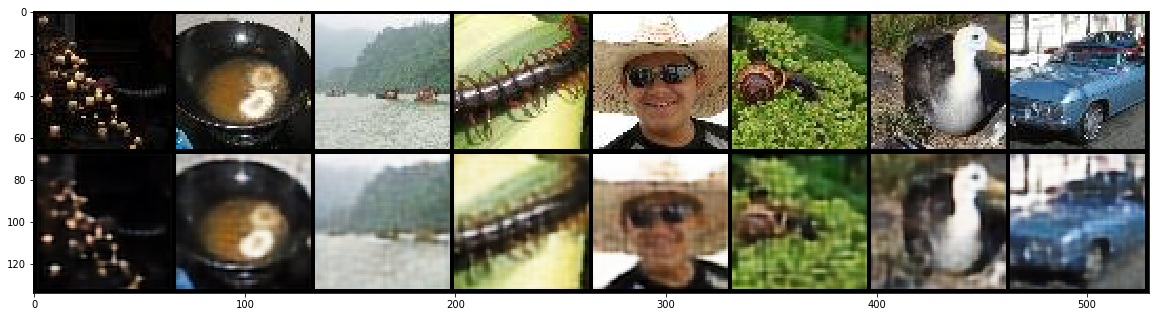

In [35]:
img_test_autoenc(net, img_train_loader)

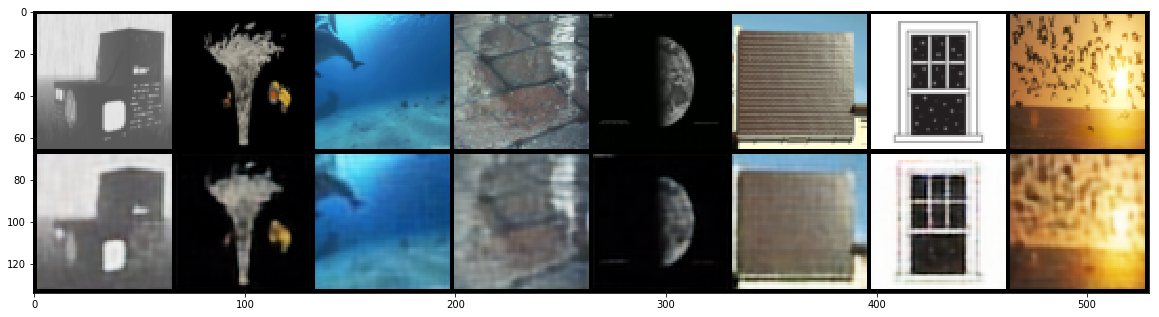

In [36]:
gif_test_autoenc(net, gif_val_loader)